<a href="https://colab.research.google.com/github/bearbearyu1223/Graph-Neural-Network-Study-Notes/blob/main/GraphSAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GraphSAGE : Inductive Representation Learning on Large Graphs

[GraphSAGE](https://arxiv.org/abs/1706.02216) is an inductive framework that leverages node feature information (e.g., text atrributes) to efficiently generate node embeddings for perviously unseen data (e.g., dynamic graphs where there are new nodes added to existing ones) without requireing a re-trainining procedure. GraphSAGE learns aggregator functions that can induce the embedding of a new node given its features and neighborhood. 

GraphSAGE has been used to power modern recommender systems on a massive scale with millions and billons of nodes and edges. See [PinSAGE](https://medium.com/pinterest-engineering/pinsage-a-new-graph-convolutional-neural-network-for-web-scale-recommender-systems-88795a107f48) from Pinterest and [food recommendations](https://www.uber.com/blog/uber-eats-graph-learning/) from UberEats.

## 1. Import Some Useful Library

In [1]:
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## 2. PubMed Dataset

PubMed is part of the Planetoid dataset. 


* It contains 19,717 scientific publications about diabetes from PubMed's database.
* Node features are TF-IDF weighted word vectors with 500 dimenions, which sumarize the documents. 
* It is a multi-class classification with three categories: diabetes mellitus experimental, diabetes mellitus type1, and diabetes mellitus type2.

PubMed dataset has been used as one of the benchmark dataset for GNNs, see [leaderboard with reference](https://paperswithcode.com/sota/node-classification-on-pubmed). It has an insanely low number of training nodes compared to the whole graph. There are only 60 samples to learn how to classify the 1000 test nodes.



In [2]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


## 3. GraphSAG

The GraphSAG algorithm can be divided into two steps: 


1. Neighbor Sampling
2. Aggregation



### 3.1 Neighbor Sampling 
Neighbor sampling relies on a classic technique used to train neural networks: **mini-batch gradient descent**. 

Mini-batch gradient descent works by breaking down a dataset into smaller batches. During training, we compute the gradient for every mini-batch instead of every epoch or every training sample. In recent years, researchers developed different strategies to create graph min-batches, which can be found on [PyG's documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html). 

Neighbor sampling considers only a fixed number of random neighbors: 


1. The sampler randomly selects a defined number of neighbors(1 hop), neighbors of neighbors (2 hops), etc.
2. The sampler outputs a subgraph which contains the target and the sampled nodes. 

The process is repeated for every node in a list or the entirety of the graph.

In PyG, neighbor sampling is implemented through the `NeighborLoader` object. Let's say we want 5 neighbors and 10 of their neighbors (num_neighbors), we can specify a `batch_size` to speed up the process by creating subgraphs for multiple target nodes (mini-batch).

Let's say we use `batch_size` of 16, then the sampler will generate `ceil(60/16)=4` subgraphs with various sizes. It allows us to process them in parallel and they're easier fit on a GPU since each sub-graph will be much smaller. 

Subgraph 0: Data(x=[390, 500], edge_index=[2, 438], y=[390], train_mask=[390], val_mask=[390], test_mask=[390], n_id=[390], e_id=[438], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[265, 500], edge_index=[2, 311], y=[265], train_mask=[265], val_mask=[265], test_mask=[265], n_id=[265], e_id=[311], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[288, 500], edge_index=[2, 333], y=[288], train_mask=[288], val_mask=[288], test_mask=[288], n_id=[288], e_id=[333], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[192, 500], edge_index=[2, 229], y=[192], train_mask=[192], val_mask=[192], test_mask=[192], n_id=[192], e_id=[229], input_id=[12], batch_size=12)


/usr/local/lib/python3.9/dist-packages/torch_geometric/sampler/neighbor_sampler.py:50: UserWarning: Using '{self.__class__.__name__}' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn("Using '{self.__class__.__name__}' without a "


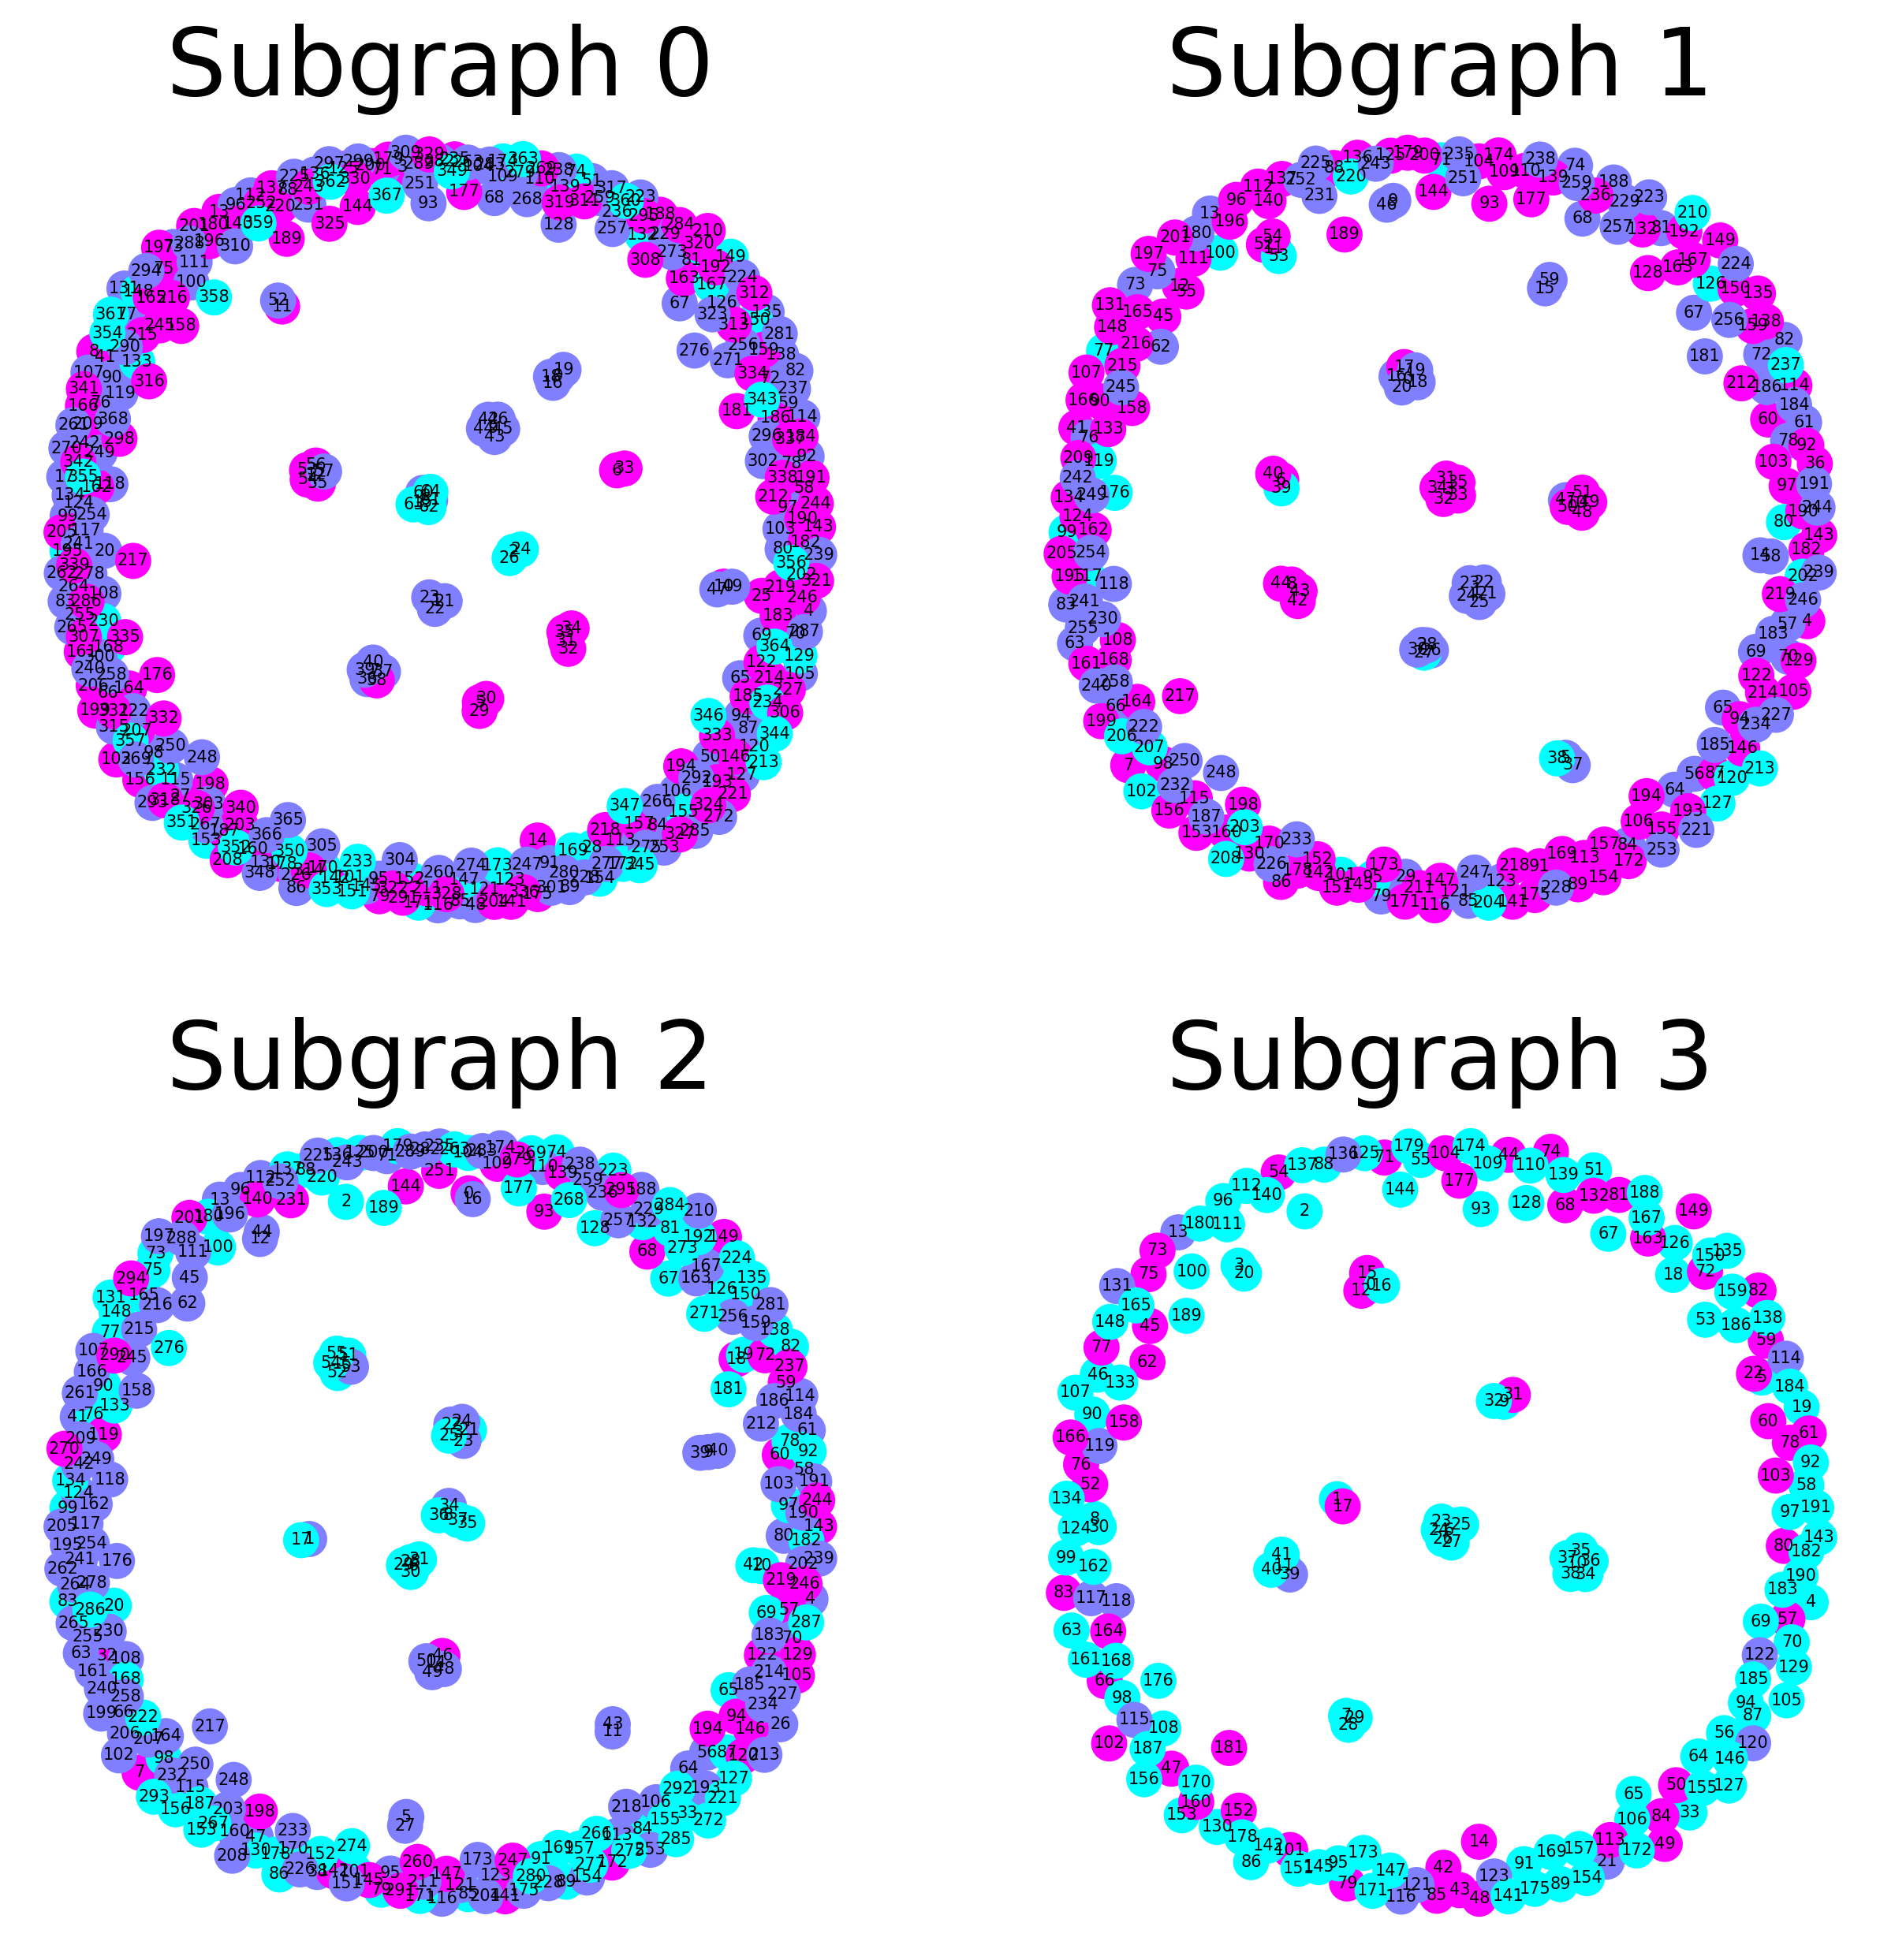

In [3]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# create train_loader with neighbor samping 
train_loader = NeighborLoader(data, num_neighbors=[5, 10], batch_size=16, input_nodes=data.train_mask)

# print info for each subgraph
for i, subgraph in enumerate(train_loader): 
  print(f'Subgraph {i}: {subgraph}')

# plot each subgraph 
fig = plt.figure(figsize=(10, 10))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
  G = to_networkx(subdata, to_undirected=True)
  ax = fig.add_subplot(pos)
  ax.set_title(f'Subgraph {idx}')
  plt.axis('off')
  nx.draw_networkx(G,
                  pos=nx.spring_layout(G, seed=0),
                  with_labels=True,
                  node_size=100,
                  node_color=subdata.y,
                  cmap="cool",
                  font_size=5
                  )
plt.show()

It should be noticed that by pruning/sampling the original graphs we will also lose a lot of information. Which can be visulized by looking at the node degress. 

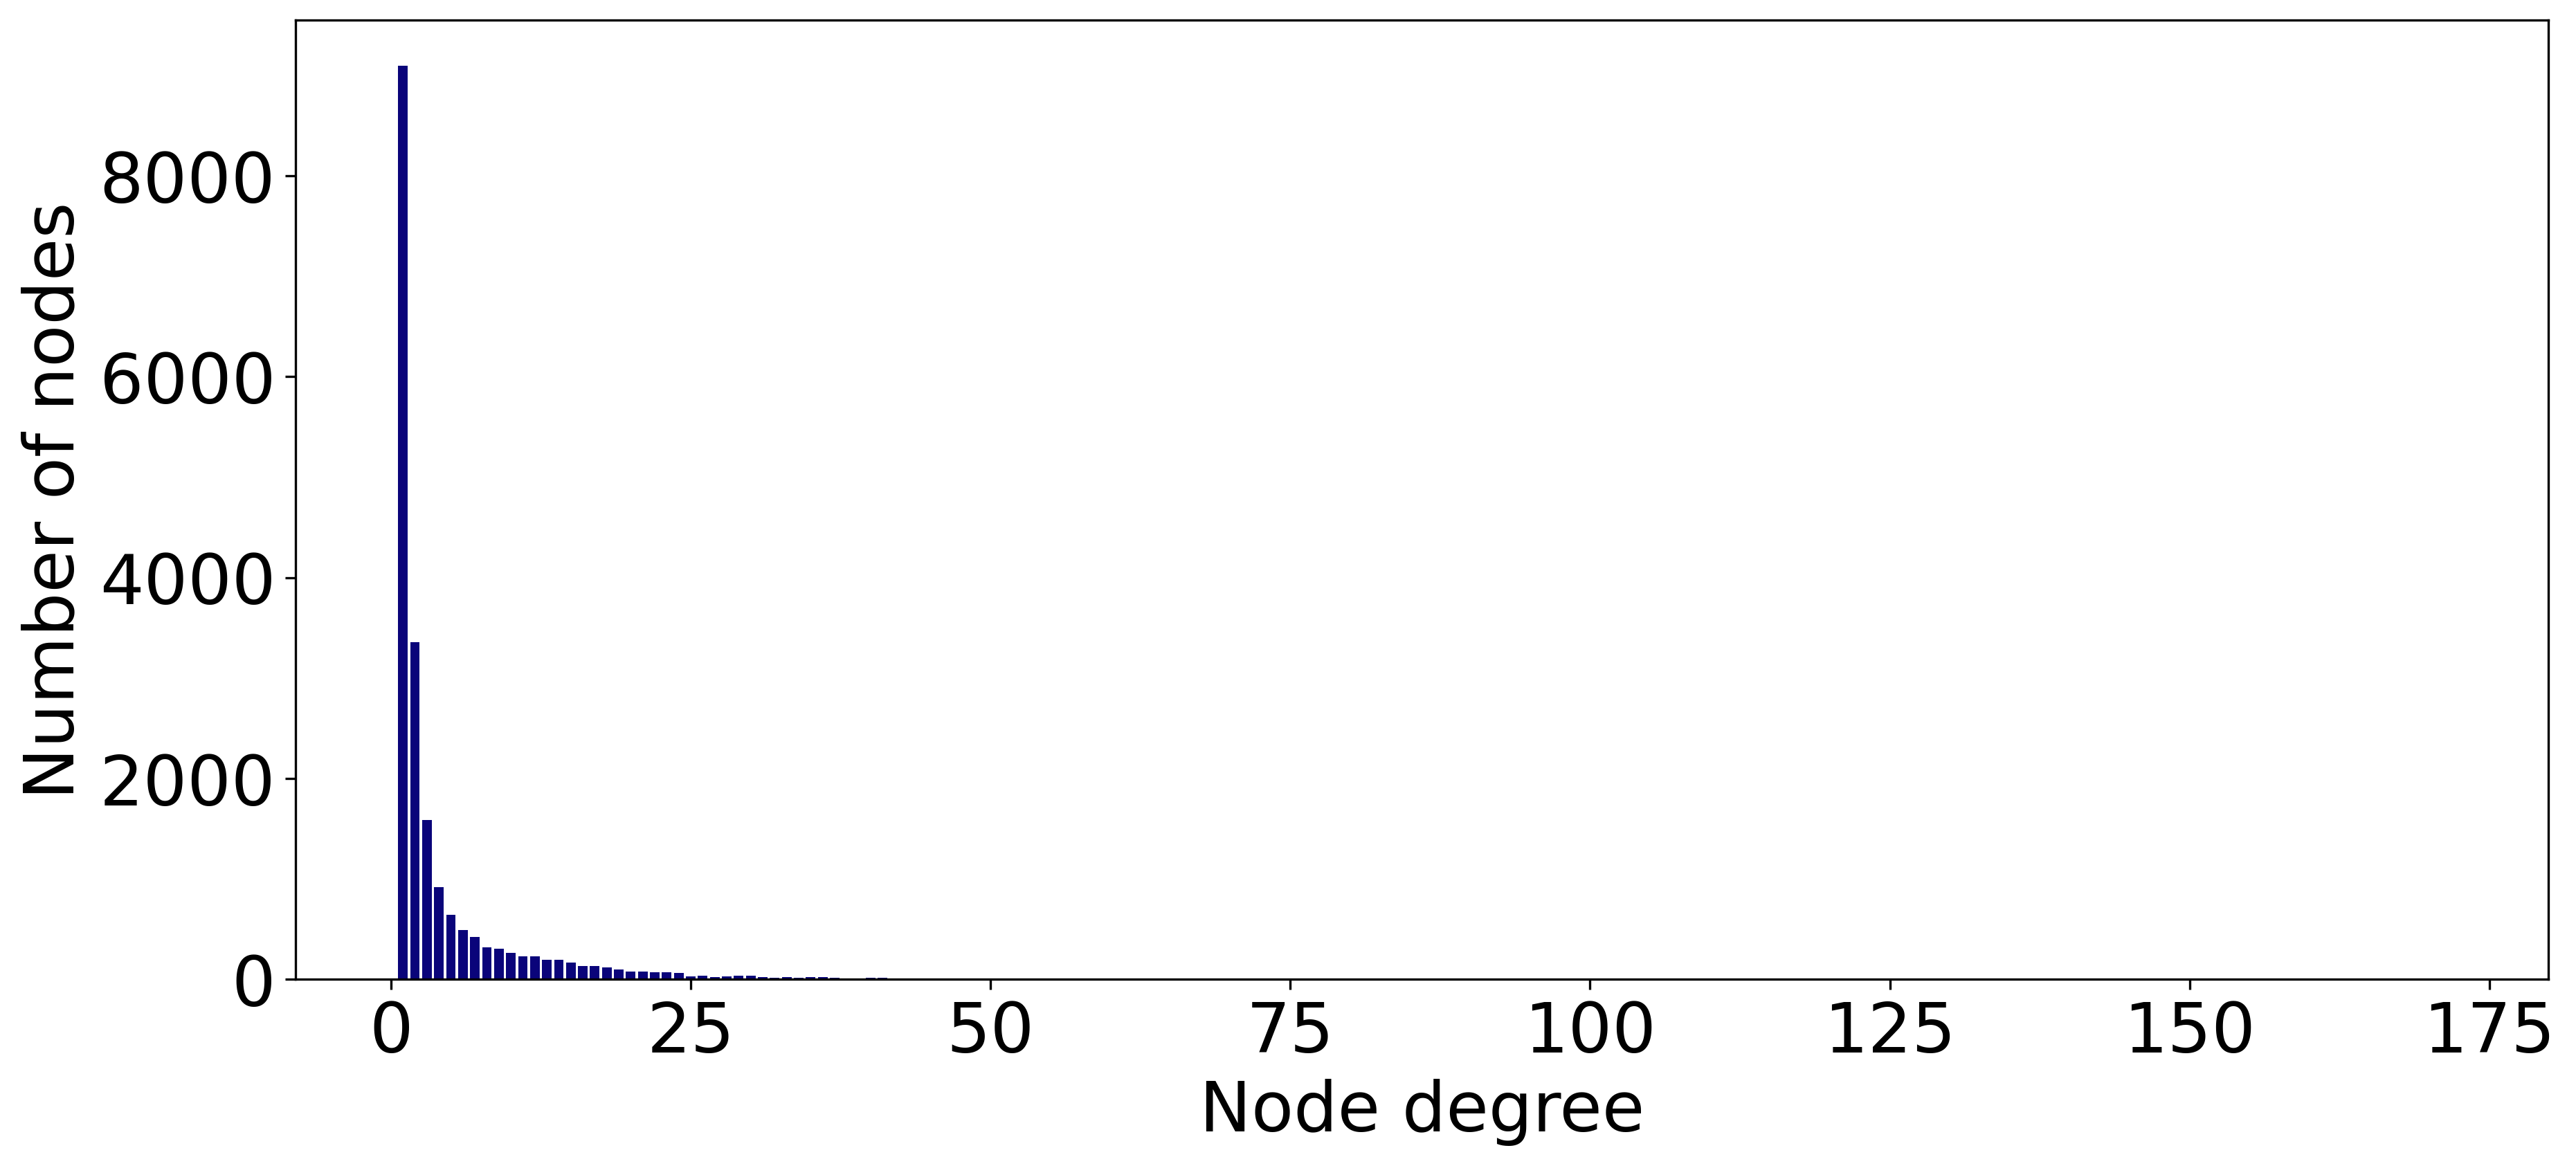

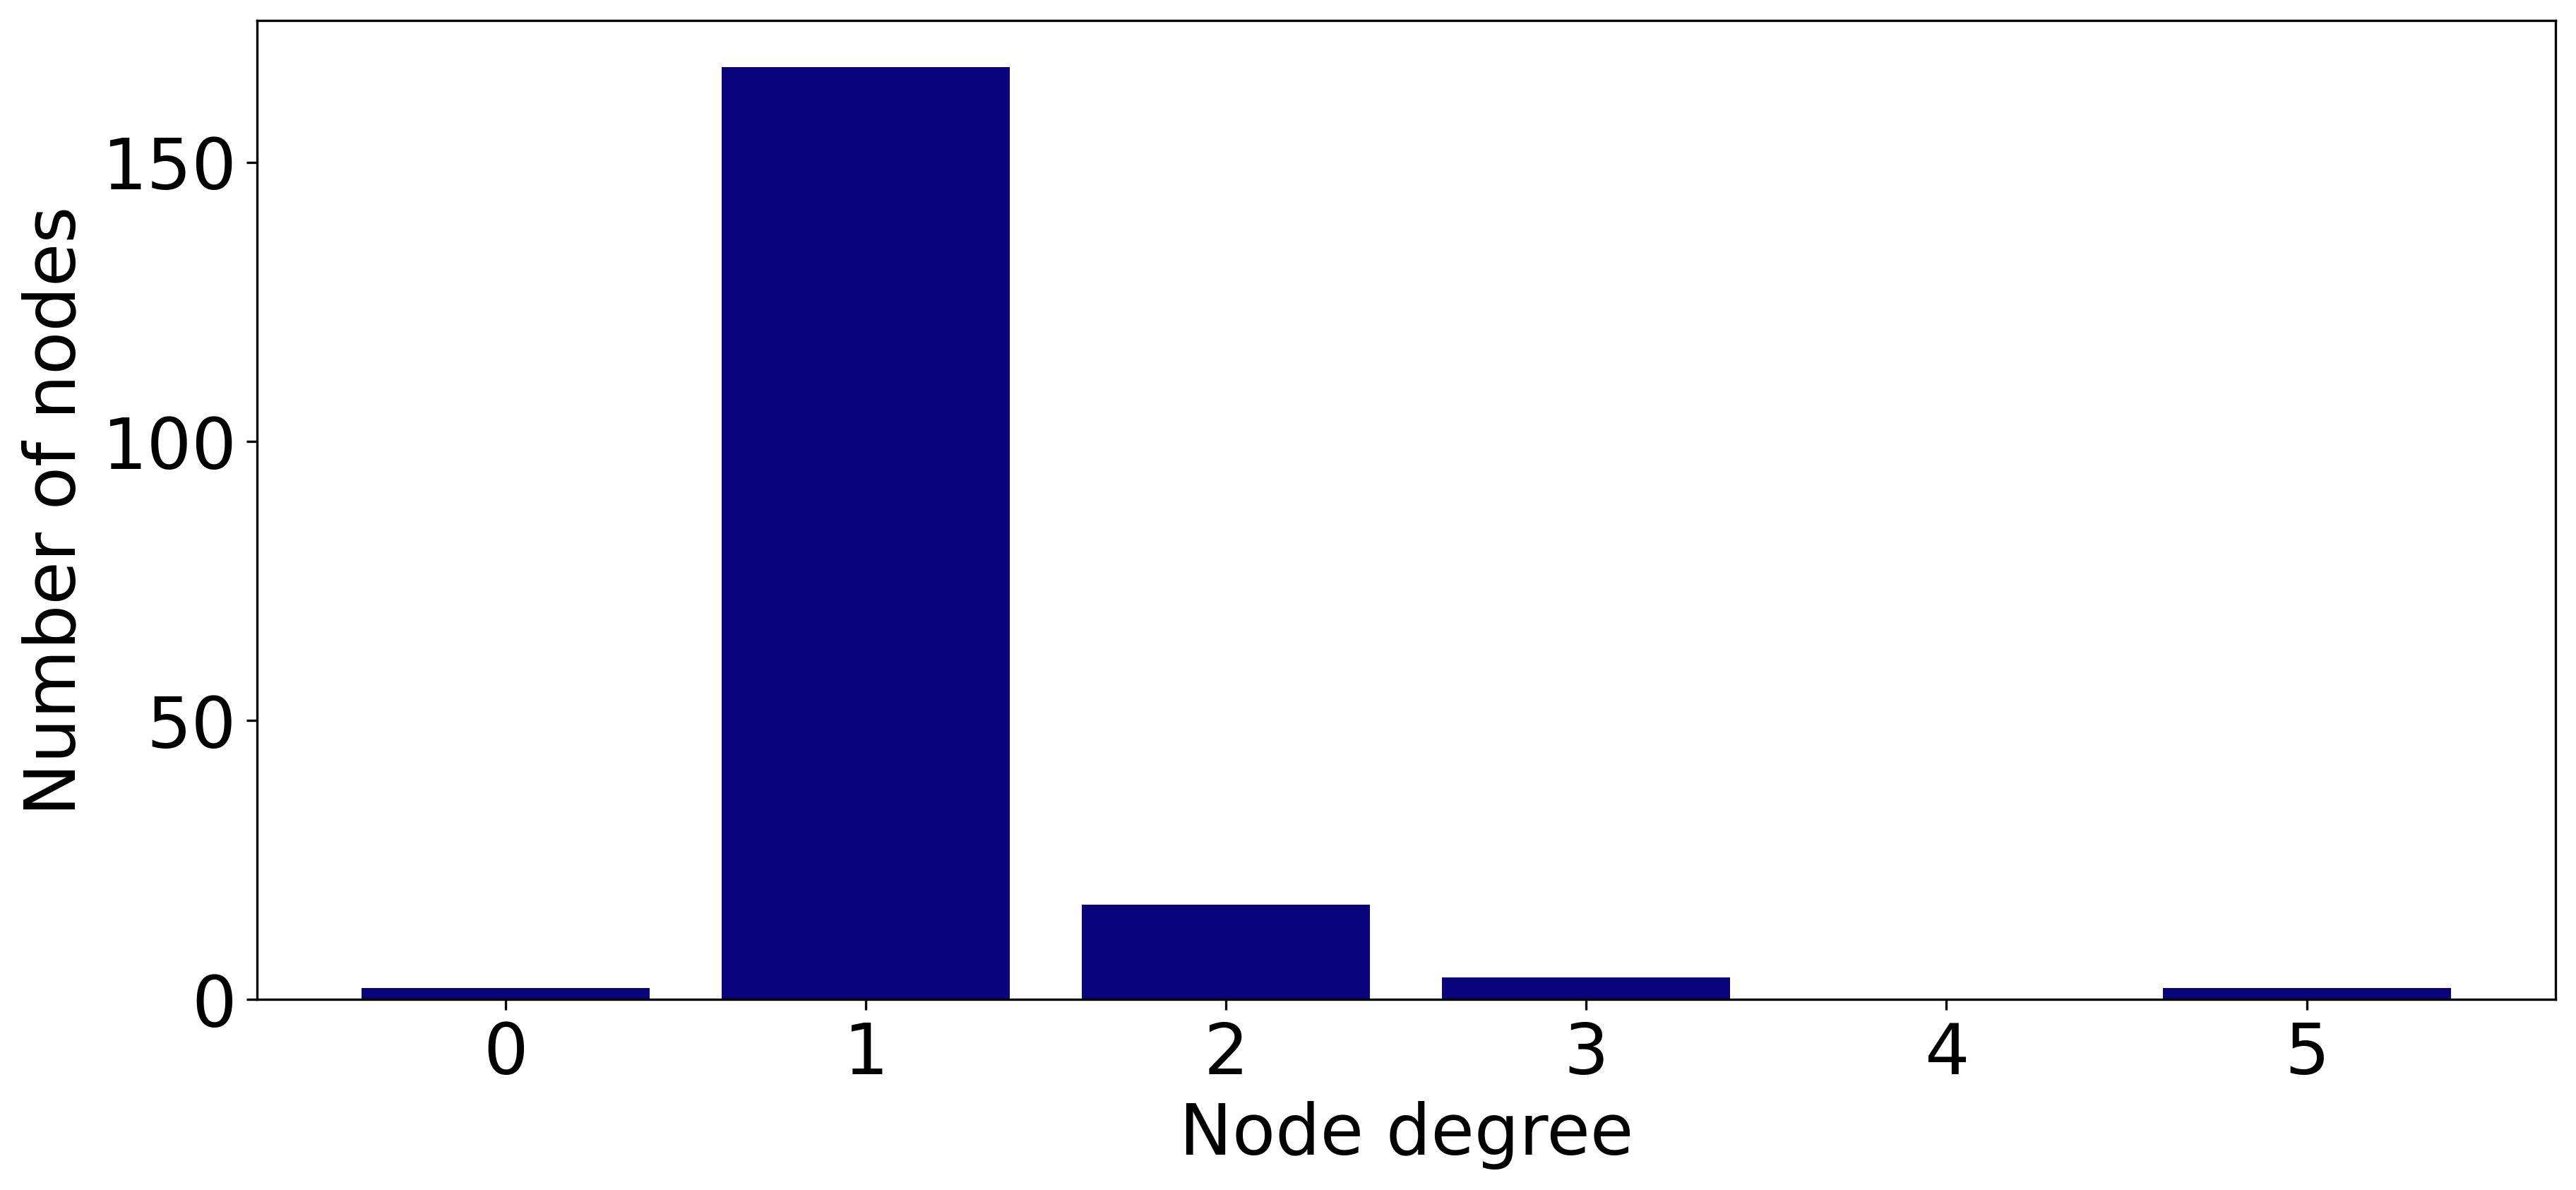

In [4]:
from torch_geometric.utils import degree
from collections import Counter

def plot_degree(data):
    # Get list of degrees for each node
    degrees = degree(data.edge_index[0]).numpy()

    # Count the number of nodes for each degree
    numbers = Counter(degrees)

    # Bar plot
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.set_xlabel('Node degree')
    ax.set_ylabel('Number of nodes')
    plt.bar(numbers.keys(),
            numbers.values(),
            color='#0A047A')

# Plot node degrees from the original graph
plot_degree(data)

# Plot node degrees from the last subgraph
plot_degree(subdata)

### 3.2 Aggregation

The aggregation process determins how to combine the feature vectors to produce the node embeddings. 

**Mean Aggregator**: 

1. The hidden features of the target node and its selected neighbors are averaged 
2. A linear transformation with a weight matrix is applied
$\displaystyle h^{'}_i = W{_1}h{_i}+ W_2 mean_{j \in {N_i}}(h_j)$




### 3.3 Benchmark the performance among GraphSAG, GCN and GAT

In [5]:
import torch 
from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv, GATv2Conv, GCNConv 
import torch.nn.functional as F

In [6]:
def accuracy(pred_y, y):
  return ((pred_y == y).sum() / len(y)).item()

In [7]:
class GraphSAGE(torch.nn.Module): 
  
  def __init__(self, dim_in, dim_h, dim_out): 
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h)
    self.sage2 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=5e-4)

  def forward(self, x, edge_index): 
    h = self.sage1(x, edge_index)
    h = F.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return F.log_softmax(h, dim=1)
  
  def fit(self, data, epochs): 
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0 

      for batch in train_loader: 
        optimizer.zero_grad()
        out = self.forward(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss = total_loss + loss
        acc = acc + accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        val_loss = val_loss + criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc = val_acc + accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

        if (epoch % 10 ==0): 
            print(f'Epoch {epoch:>3} '
                  f'| Train Loss: {total_loss/len(train_loader):.3f} '
                  f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                  f'{val_loss/len(train_loader):.2f} | Val Acc: '
                  f'{val_acc/len(train_loader)*100:.2f}%')

In [8]:
class GAT(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=heads)
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gat2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])
        
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3}'
                  f' | Train Loss: {loss:.3f}'
                  f' | Train Acc: {acc*100:>6.2f}%'
                  f' | Val Loss: {val_loss:.2f}' 
                  f' | Val Acc: {val_acc*100:.2f}%')

In [9]:
class GCN(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.gcn1(x, edge_index).relu()
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3}'
                  f' | Train Loss: {loss:.3f}'
                  f' | Train Acc: {acc*100:>6.2f}%'
                  f' | Val Loss: {val_loss:.2f}' 
                  f' | Val Acc: {val_acc*100:.2f}%')

In [10]:
@torch.no_grad()
def test(model, data):
  model.eval()
  out = model(data.x, data.edge_index)
  acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
  return acc

In [11]:
%%time

# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 200)

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 0.270 | Train Acc:  14.06% | Val Loss: 0.27 | Val Acc: 9.62%
Epoch   0 | Train Loss: 0.537 | Train Acc:  28.12% | Val Loss: 0.54 | Val Acc: 26.28%
Epoch   0 | Train Loss: 0.815 | Train Acc:  30.76% | Val Loss: 0.82 | Val Acc: 26.28%
Epoch   0 | Train Loss: 1.105 | Train Acc:  30.76% | Val Loss: 1.10 | Val Acc: 31.28%
Epoch  10 | Train Loss: 0.249 | Train Acc:  23.53% | Val Loss: 0.27 | Val Acc: 10.00%
Epoch  10 | Train Loss: 0.501 | Train Acc:  46.97% | Val Loss: 0.54 | Val Acc: 35.00%
Epoch  10 | Train Loss: 0.747 | Train Acc:  69.03% | Val Loss: 0.81 | Val Acc: 43.33%
Epoch  10 | Train Loss: 0.989 | Train Acc:  94.03% | Val Loss: 1.07 | Val Acc: 58.33%
Epoch  20 | Train Loss: 0.205 | Train Acc:  23.53% | Val Loss: 0.27 | Val Acc: 15.00%
Epoch  20 | Train Loss: 0.416 | Train Acc:  48.53% | Val Loss: 0.53 | Val Acc: 35.83%
Epoch  20 | Train Loss: 0.607 | Train Acc:  72.14%

In [12]:
%%time

# Create GCN
gcn = GCN(dataset.num_features, 64, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, 200)

# Test
print(f'\nGCN test accuracy: {test(gcn, data)*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(500, 64)
  (gcn2): GCNConv(64, 3)
)
Epoch   0 | Train Loss: 1.099 | Train Acc:  21.67% | Val Loss: 1.10 | Val Acc: 31.60%
Epoch  10 | Train Loss: 1.070 | Train Acc:  83.33% | Val Loss: 1.08 | Val Acc: 62.80%
Epoch  20 | Train Loss: 1.029 | Train Acc:  91.67% | Val Loss: 1.06 | Val Acc: 72.00%
Epoch  30 | Train Loss: 0.977 | Train Acc:  96.67% | Val Loss: 1.03 | Val Acc: 75.20%
Epoch  40 | Train Loss: 0.926 | Train Acc:  93.33% | Val Loss: 0.99 | Val Acc: 74.80%
Epoch  50 | Train Loss: 0.866 | Train Acc:  91.67% | Val Loss: 0.96 | Val Acc: 75.00%
Epoch  60 | Train Loss: 0.816 | Train Acc:  95.00% | Val Loss: 0.93 | Val Acc: 74.20%
Epoch  70 | Train Loss: 0.739 | Train Acc:  96.67% | Val Loss: 0.89 | Val Acc: 73.60%
Epoch  80 | Train Loss: 0.700 | Train Acc:  95.00% | Val Loss: 0.86 | Val Acc: 74.00%
Epoch  90 | Train Loss: 0.635 | Train Acc:  95.00% | Val Loss: 0.83 | Val Acc: 76.60%
Epoch 100 | Train Loss: 0.586 | Train Acc:  96.67% | Val Loss: 0.80 | Val Acc: 75

In [13]:
%%time

# Create GAT
gat = GAT(dataset.num_features, 64, dataset.num_classes)
print(gat)

# Train
gat.fit(data, 200)

# Test
print(f'\nGAT test accuracy: {test(gat, data)*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(500, 64, heads=8)
  (gat2): GATv2Conv(512, 3, heads=8)
)
Epoch   0 | Train Loss: 3.166 | Train Acc:   0.00% | Val Loss: 3.16 | Val Acc: 2.40%
Epoch  10 | Train Loss: 2.344 | Train Acc:  83.33% | Val Loss: 2.37 | Val Acc: 67.00%
Epoch  20 | Train Loss: 1.459 | Train Acc:  91.67% | Val Loss: 1.54 | Val Acc: 70.20%
Epoch  30 | Train Loss: 0.984 | Train Acc:  86.67% | Val Loss: 1.07 | Val Acc: 71.60%
Epoch  40 | Train Loss: 0.804 | Train Acc:  90.00% | Val Loss: 0.93 | Val Acc: 73.60%
Epoch  50 | Train Loss: 0.683 | Train Acc:  88.33% | Val Loss: 0.85 | Val Acc: 72.80%
Epoch  60 | Train Loss: 0.600 | Train Acc:  91.67% | Val Loss: 0.78 | Val Acc: 76.00%
Epoch  70 | Train Loss: 0.495 | Train Acc:  93.33% | Val Loss: 0.73 | Val Acc: 75.60%
Epoch  80 | Train Loss: 0.425 | Train Acc:  95.00% | Val Loss: 0.69 | Val Acc: 76.80%
Epoch  90 | Train Loss: 0.369 | Train Acc:  93.33% | Val Loss: 0.66 | Val Acc: 76.00%
Epoch 100 | Train Loss: 0.312 | Train Acc:  96.67% | Val Lo

## Summary 

**GCN** is a realization of **GAT** by setting the attention function to be the spectral normalized adjecny matrix. Both GCN and GAT are **transductive** in nature because parameters are learned through convolutions with both training and test data (we masked the information about the test nodes during training, but we didn't hide their presence in the adjaceny matrix). Therefore, they have to be retrained when new nodes are added to the graph. 

Thanks to neighorhood sampling, **GraphSAGE** is designed to be an inductive model, it does not require seeing every neighbor to calculate the an embedding. 